# Segmentatie tutorial

https://www.tensorflow.org/tutorials/images/segmentation

In [1]:
import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow_examples.models.pix2pix import pix2pix

from IPython.display import clear_output
import matplotlib.pyplot as plt

from ipywidgets import FloatProgress

In [2]:
#!jupyter nbextension enable --py widgetsnbextension

In [3]:
# import pandas as pd
# pd.DataFrame([5,4,5,4])

## Dataset ophalen

In [4]:
dataset, info = tfds.load('oxford_iiit_pet:3.*.*', with_info=True)

In [5]:
dataset['train'].element_spec

{'file_name': TensorSpec(shape=(), dtype=tf.string, name=None),
 'image': TensorSpec(shape=(None, None, 3), dtype=tf.uint8, name=None),
 'label': TensorSpec(shape=(), dtype=tf.int64, name=None),
 'segmentation_mask': TensorSpec(shape=(None, None, 1), dtype=tf.uint8, name=None),
 'species': TensorSpec(shape=(), dtype=tf.int64, name=None)}

### Afbeeldingen in juiste vorm krijgen

In [6]:
def normalize(input_image, input_mask):
    input_image = tf.cast(input_image, tf.float32) / 255.0
    # input_mask = afbeelding met elke pixel ingekleurd. 
    # -1 om {1,2,3} => {0,1,2}
    input_mask -= 1
    return input_image, input_mask

In [7]:
def load_image(datapoint):
    input_image = tf.image.resize(datapoint['image'], (128, 128))
    input_mask = tf.image.resize(datapoint['segmentation_mask'], (128, 128))

    input_image, input_mask = normalize(input_image, input_mask)

    return input_image, input_mask

In [8]:
# num_parallel_calls => om meerdere threads te gebruiken
train_images = dataset['train'].map(load_image, num_parallel_calls=tf.data.AUTOTUNE)
test_images = dataset['test'].map(load_image, num_parallel_calls=tf.data.AUTOTUNE)

In [9]:
import numpy as np
print("Mask propoerties:")
for img, mask in train_images:
    print(f"Min: {np.min(mask)};\nMax: {np.max(mask)};\nShape: {mask.shape};")
    break

Mask propoerties:
Min: 0.0;
Max: 2.0;
Shape: (128, 128, 1);


## Data opdelen in batches +  vervormen

Door te vervormen kan men meer images gebruiken. Eén vervormde image zorgt ervoor dat je de origineel hebt en de vervormde.<br>
Het wordt ook gebruikt om meer diversiteit in de dataset te krijgen.

In [10]:
class Augment(tf.keras.layers.Layer):
    def __init__(self, seed=42):
        super().__init__()
        # both use the same seed, so they'll make the same random changes.
        self.augment_inputs = tf.keras.layers.RandomFlip(mode="horizontal", seed=seed)
        self.augment_labels = tf.keras.layers.RandomFlip(mode="horizontal", seed=seed)

    def call(self, inputs, labels):
        inputs = self.augment_inputs(inputs)
        labels = self.augment_labels(labels)
        return inputs, labels

In [11]:
TRAIN_LENGTH = info.splits['train'].num_examples
BATCH_SIZE = 64
BUFFER_SIZE = 1000
STEPS_PER_EPOCH = TRAIN_LENGTH // BATCH_SIZE

In [12]:
print(f"Train length: {TRAIN_LENGTH}")
print(f"Test length: {info.splits['test'].num_examples}")

Train length: 3680
Test length: 3669


In [13]:
train_batches = (
    train_images
    .cache()
    .shuffle(BUFFER_SIZE)
    .batch(BATCH_SIZE)
    .repeat() # Deze dataset wordt herhaald (oneindig).
    .map(Augment()) # De images worden willekeurig (seed = 42) vervormt (RandomFlip)
    .prefetch(buffer_size=tf.data.AUTOTUNE))

test_batches = test_images.batch(BATCH_SIZE)

In [14]:
batch = next(iter(train_batches))
input_batch, mask_batch = batch
print(input_batch.shape)
print(mask_batch.shape)

(64, 128, 128, 3)
(64, 128, 128, 1)


## Toon image en label

In [15]:
def display(display_list):
    plt.figure(figsize=(15, 15))

    title = ['Input Image', 'True Mask', 'Predicted Mask']

    for i in range(len(display_list)):
        plt.subplot(1, len(display_list), i+1)
        plt.title(title[i])
        plt.imshow(tf.keras.utils.array_to_img(display_list[i]))
        plt.axis('off')
    plt.show()

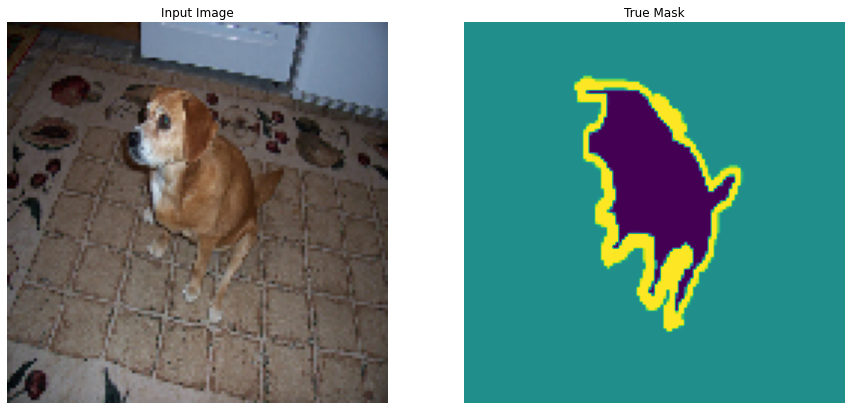

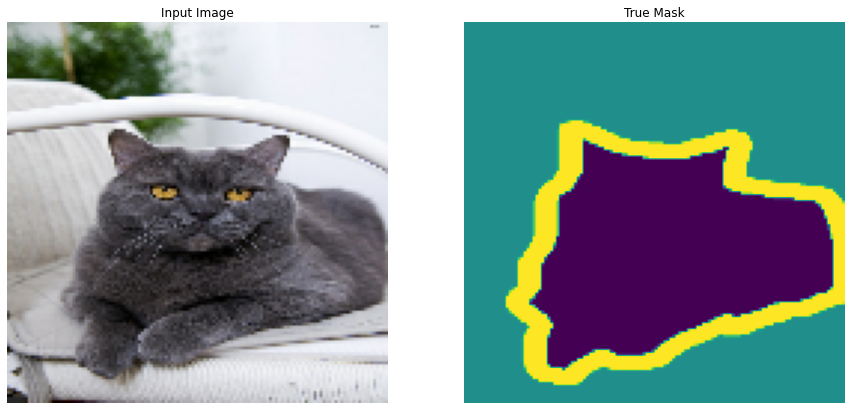

In [16]:
for images, masks in train_batches.take(2):
    sample_image, sample_mask = images[0], masks[0]
    display([sample_image, sample_mask])

## Het model: U-Net

U-Net heeft een encoder (downsampler) en een decoder (upsampler). MobileNetV2 is een encoder. pix2pix is een decoder.<br>
De encoder (= MobileNetV2) zal niet getraind worden. Deze is namelijk al getraind.

### MobileNetV2 is een getraind CNN

In [17]:
base_model = tf.keras.applications.MobileNetV2(input_shape=[128, 128, 3], include_top=False)

# Use the activations of these layers
layer_names = [
    'block_1_expand_relu',   # 64x64
    'block_3_expand_relu',   # 32x32
    'block_6_expand_relu',   # 16x16
    'block_13_expand_relu',  # 8x8
    'block_16_project',      # 4x4
]
base_model_outputs = [base_model.get_layer(name).output for name in layer_names]

# Create the feature extraction model
down_stack = tf.keras.Model(inputs=base_model.input, outputs=base_model_outputs)

down_stack.trainable = False

In [18]:
len(base_model.layers)

154

Bij upsampling wordt het aantal filters/feature channels meegegeven en de grootte van de filter. Zie:<br>
https://github.com/tensorflow/examples/blob/master/tensorflow_examples/models/pix2pix/pix2pix.py

In [19]:
up_stack = [
    pix2pix.upsample(512, 3),  # 4x4 -> 8x8
    pix2pix.upsample(256, 3),  # 8x8 -> 16x16
    pix2pix.upsample(128, 3),  # 16x16 -> 32x32
    pix2pix.upsample(64, 3),   # 32x32 -> 64x64
]

#### Downsampling en upsampling: Meer uitleg bij diagram

In [20]:
def unet_model(output_channels:int):
    inputs = tf.keras.layers.Input(shape=[128, 128, 3])

    # Downsampling through the model
    skips = down_stack(inputs) # Zie het diagram: Input -> Model Functional
    x = skips[-1]
    skips = reversed(skips[:-1])

    # Upsampling and establishing the skip connections
    for up, skip in zip(up_stack, skips):
        x = up(x)
        concat = tf.keras.layers.Concatenate()
        x = concat([x, skip])

    # This is the last layer of the model
    last = tf.keras.layers.Conv2DTranspose(
        filters=output_channels, kernel_size=3, strides=2,
        padding='same')  #64x64 -> 128x128

    x = last(x)

    return tf.keras.Model(inputs=inputs, outputs=x)

### Diagram van de lagen

Zie online tutorial om te zien wat dit genereert. <br>
Dit toont een diagram van wat de verschillende lagen in het model doen. <br>
tf.keras.utils.plot_model(model, show_shapes=True)

#### "Model: Functional" is in dit geval down_stack

In [21]:
down_stack

In [22]:
down_stack.input

<KerasTensor: shape=(None, 128, 128, 3) dtype=float32 (created by layer 'input_1')>

In [23]:
# Vermoedelijk is bij shape=(None, 64, 64, 96) de dimensies van de afbeelding 64 bij 64 en het aantal
# filters of de resulterende feature maps.
down_stack.output

[<KerasTensor: shape=(None, 64, 64, 96) dtype=float32 (created by layer 'block_1_expand_relu')>,
 <KerasTensor: shape=(None, 32, 32, 144) dtype=float32 (created by layer 'block_3_expand_relu')>,
 <KerasTensor: shape=(None, 16, 16, 192) dtype=float32 (created by layer 'block_6_expand_relu')>,
 <KerasTensor: shape=(None, 8, 8, 576) dtype=float32 (created by layer 'block_13_expand_relu')>,
 <KerasTensor: shape=(None, 4, 4, 320) dtype=float32 (created by layer 'block_16_project')>]

#### De sequential layers zijn van up_stack

In [24]:
up_stack

#### Het concatineren gebeurt in de functie unet_model(output_channels)

Dit is een afbeelding van het internet: <br>
https://www.tensorflow.org/tutorials/images/segmentation_files/output_sw82qF1Gcovr_0.png
![Dit is een afbeelding van het internet:](https://www.tensorflow.org/tutorials/images/segmentation_files/output_sw82qF1Gcovr_0.png)

### Compiling

In [25]:
OUTPUT_CLASSES = 3

model = unet_model(output_channels=OUTPUT_CLASSES)
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

## Geef elke pixel een kleur

Elke pixel wordt gecategoriseerd volgens de hoogste waarde (hoogste waarschijnlijkheid) die het bevat voor een bepaalde klasse. Dit resulteert in een verzameling labels met een geheel getal als waarde. Dit getal stelt de klasse voor waaronder de pixel uiteindelijk valt.

In [26]:
def create_mask(pred_mask):
    pred_mask = tf.argmax(pred_mask, axis=-1)
    pred_mask = pred_mask[..., tf.newaxis]
    return pred_mask[0]

## In beeld brengen

In [27]:
def show_predictions(dataset=None, num=1):
    if dataset:
        for image, mask in dataset.take(num):
            pred_mask = model.predict(image)
            display([
                image[0], 
                mask[0], 
                create_mask(pred_mask)
            ])
    else:
        display([
            sample_image, 
            sample_mask,
            create_mask(model.predict(sample_image[tf.newaxis, ...]))
        ])

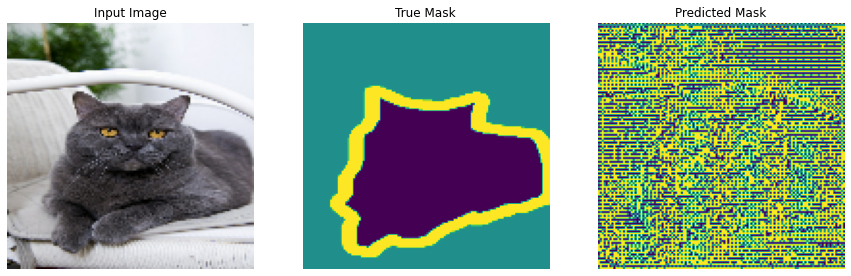

In [28]:
show_predictions()

In [29]:
class DisplayCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        clear_output(wait=True)
        show_predictions()
        print ('\nSample Prediction after epoch {}\n'.format(epoch+1))

## Het model trainen

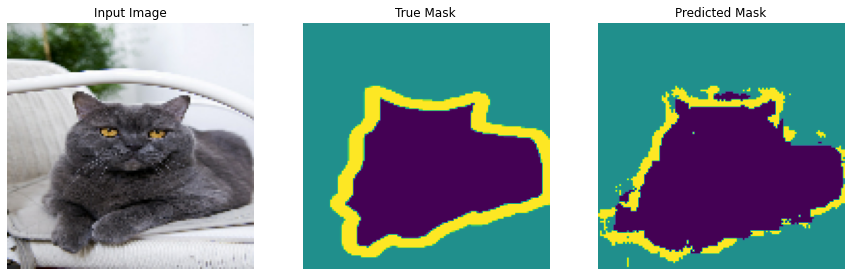


Sample Prediction after epoch 4

57/57 [==============================] - 274s 5s/step - loss: 0.2625 - accuracy: 0.8900 - val_loss: 0.2921 - val_accuracy: 0.8786


In [30]:
EPOCHS = 4
VAL_SUBSPLITS = 5
VALIDATION_STEPS = info.splits['test'].num_examples//BATCH_SIZE//VAL_SUBSPLITS

model_history = model.fit(train_batches, epochs=EPOCHS,
                          steps_per_epoch=STEPS_PER_EPOCH,
                          validation_steps=VALIDATION_STEPS,
                          validation_data=test_batches,
                          callbacks=[DisplayCallback()])

## Visualiseer de voorspellingen

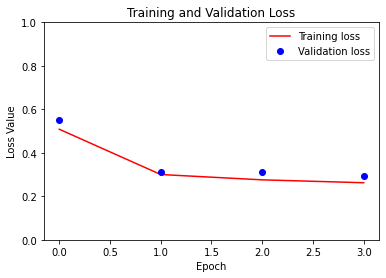

In [31]:
loss = model_history.history['loss']
val_loss = model_history.history['val_loss']

plt.figure()
plt.plot(model_history.epoch, loss, 'r', label='Training loss')
plt.plot(model_history.epoch, val_loss, 'bo', label='Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss Value')
plt.ylim([0, 1])
plt.legend()
plt.show()

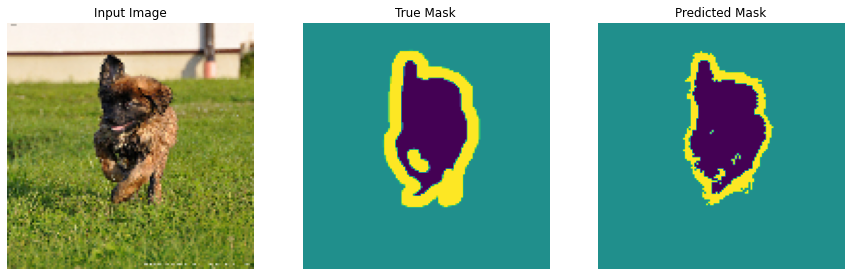

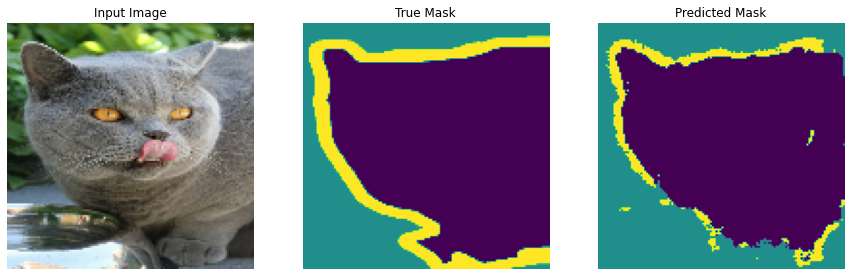

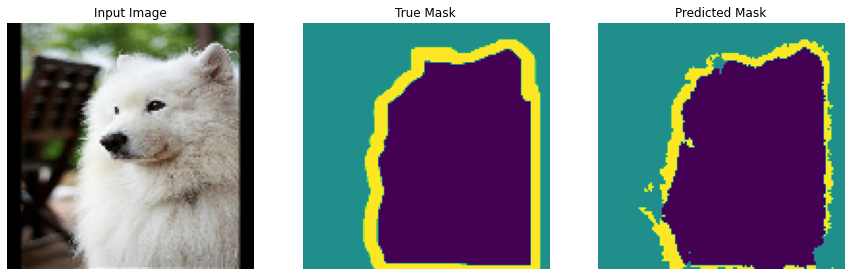

In [32]:
show_predictions(test_batches, 3)

## Gewichten toevoegen aan classes

Bij segmentatie kunnen sommige klasses veel meer toegewezen worden aan pixels, omdat bijvoorbeeld de afbeeldingen heel dicht op het te identificeren object inzoomt of te ver. Dit zorgt voor "imbalanced data". Dit kan vermeden worden door aan sommige klasses gewichten te hangen om fouten harder of zachter te bestraffen.

Imbalanced data kwam ook voor in de cursus. Als een model een ziekte wil voorspellen die maar bij 1 % van de mensen voorkomt, dan kan dit model snel 99% accuraat zijn als het enkel en alleen zegt dat de ziekte afwezig is.

### Pogingen om gewichten te gebruiken

In [33]:
try:
    model_history = model.fit(train_batches, epochs=EPOCHS,
                            steps_per_epoch=STEPS_PER_EPOCH,
                            class_weight = {0:2.0, 1:2.0, 2:1.0})
    assert False
except Exception as e:
    print(f"Expected {type(e).__name__}: {e}")

Expected ValueError: `class_weight` not supported for 3+ dimensional targets.


In [34]:
label = [0,0]
prediction = [[-3., 0], [-3, 0]] 
sample_weight = [1, 10] 

loss = tf.losses.SparseCategoricalCrossentropy(from_logits=True,
                                               reduction=tf.losses.Reduction.NONE)
loss(label, prediction, sample_weight).numpy()

array([ 3.0485873, 30.485874 ], dtype=float32)

### Elke pixel krijgt een gewicht

In [35]:
def add_sample_weights(image, label):
    # The weights for each class, with the constraint that:
    #     sum(class_weights) == 1.0
    class_weights = tf.constant([2.0, 2.0, 1.0])
    class_weights = class_weights/tf.reduce_sum(class_weights)

    # Create an image of `sample_weights` by using the label at each pixel as an 
    # index into the `class weights`.
    sample_weights = tf.gather(class_weights, indices=tf.cast(label, tf.int32))

    return image, label, sample_weights

In [36]:
train_batches.map(add_sample_weights).element_spec

(TensorSpec(shape=(None, 128, 128, 3), dtype=tf.float32, name=None),
 TensorSpec(shape=(None, 128, 128, 1), dtype=tf.float32, name=None),
 TensorSpec(shape=(None, 128, 128, 1), dtype=tf.float32, name=None))

In [40]:
for image, label, sample_weights in train_batches.map(add_sample_weights):
    print(np.min(sample_weights))
    break

0.2


In [37]:
weighted_model = unet_model(OUTPUT_CLASSES)
weighted_model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy'])

In [38]:
weighted_model.fit(
    train_batches.map(add_sample_weights),
    epochs=1,
    steps_per_epoch=10)

10/10 [==============================] - 46s 4s/step - loss: 0.2962 - accuracy: 0.6434
